## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

### Salih Eren Yüzbaşıoğlu - 2220356040

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction

This part of the assignment focuses on building and training a Convolutional Neural Network (CNN) from scratch for image classification. CNNs are a class of deep neural networks that have shown state-of-the-art performance in various computer vision tasks. They are particularly well-suited for image data due to their ability to automatically learn hierarchical features through convolutional layers. These features capture spatial dependencies and patterns, enabling the network to learn abstract representations of images effectively.

**Key components of a CNN architecture:**

*   **Convolutional Layers:** These layers apply filters to the input image, extracting features such as edges, corners, and textures.
*   **Activation Functions:** Non-linear functions (like ReLU) introduce non-linearity, enabling the network to learn complex mappings.
*   **Pooling Layers:** Reduce the spatial dimensions of feature maps, decreasing the number of parameters and increasing robustness.
*   **Fully Connected Layers:** Used for final classification, mapping the extracted features to output classes.

**Why CNNs for image classification?**

  CNNs excel at image classification because they leverage the spatial structure of images effectively. They automatically learn relevant features, reducing the need for manual feature engineering. The hierarchical structure of a CNN captures increasingly complex features, making them suitable for challenging vision tasks.

**Dataset Description:**

  We will be using the "Animals-10" dataset, consisting of 4500 images spread across 10 different animal classes. The dataset is split into training (3000 images), validation (750 images), and test (750 images) sets, maintaining balanced class representation within each split.

### 1.2. Data Loading and Preprocessing (3 points)

In [1]:
## Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:

# Define transformations for the training dataset (with augmentation)
train_transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Resize((256, 256)),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomAffine(degrees=(-42, 42),translate=(0.15, 0.15), scale=(0.7, 1.2),shear=(15,15)),

])

# Define transformations for validation/test dataset (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),           # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
dataset_path = "dataset2"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=None)  # Temporarily set transform=None

# Split into training, validation, and test sets
train_size = 3000
val_size = 750
test_size = 750

# seed
torch.manual_seed(1453 + 1)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)


# Assign the appropriate transforms to each dataset
train_dataset.dataset.transform = train_transform  # Apply augmentation to training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset.dataset.transform = val_test_transform  # Standard preprocessing for validation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

test_dataset.dataset.transform = val_test_transform  # Standard preprocessing for test

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Class-to-index mapping
print("Class-to-Index Mapping:", full_dataset.class_to_idx)


Class-to-Index Mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


### 1.3. Define your CNN architecture (7 points)
  I tried many different architectures and the best one with low amount parameters and smaller than 4gb(my rtx 3050 memory) is the one below. I used 5 convolutional layers with batch normalization, max-pooling, activation functions and a dropout layer to prevent overfitting. The network then uses fully connected layers at the end for classification with ReLU activations.

  The CNN architecture used in this section consists of five convolutional layers interspersed with batch normalization, max-pooling, activation functions and a dropout layer to prevent overfitting. The network then uses fully connected layers at the end for classification with ReLU activations.

  **Explanation:**

  *   **Convolutional Layers:** Each convolutional layer is followed by batch normalization and a ReLU activation function. The number of filters and kernel sizes used help with extracting increasingly complex features.
  *   **Max Pooling:** Max pooling layers reduce the dimensionality, helping to reduce the computational load.
  *   **Fully Connected Layers:** The fully connected layers before output are used to map learned features to class outputs and batch normalization is used after the first fully connected layer to stabilize learning and prevent overfitting.
  *   **ReLU Activations:** The ReLU activation function is used to introduce non-linearity.
  *   **Dropout:** Dropout is added to fully connected layer to prevent overfitting.
  
  Batch normalization is added to stabilize and increase learning.

  **Activation function choice:**

  ReLU (Rectified Linear Unit) activation is used here after every batch normalization and convolutional layer because they are computationally efficient and help to solve the vanishing gradient problem effectively. Leaky ReLU is used for not making the output 0 in some cases and improving overall performance. 

In [4]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes

# try with batch normalization
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # parameter count = 3*3*3*16 + 3*3*16*32 + 3*3*32*64 + 64*8*8*512 + 512*256 + 256*2
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 16, 128) # highest parameter count
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.conv5(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(F.leaky_relu(self.bn_fc1(self.fc1(x))))
        x = F.leaky_relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x
# 72% after about 120 epochs

# # create CNN with different kernel size that eventually which gets concatenated
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         # parameter count = 3*3*3*16 + 3*3*16*32 + 3*3*32*64 + 64*8*8*512 + 512*256 + 256*2
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.conv1_2 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
#         self.conv1_3 = nn.Conv2d(3, 16, kernel_size=7, padding=3)
#         self.bn1 = nn.BatchNorm2d(48)
#         self.conv2 = nn.Conv2d(48, 24, kernel_size=3, padding=1)
#         self.conv2_2 = nn.Conv2d(48, 24, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm2d(48)
#         self.conv3 = nn.Conv2d(48, 32, kernel_size=3, padding=1)
#         self.conv3_2 = nn.Conv2d(48, 32, kernel_size=5, padding=2)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.fc1 = nn.Linear(64 * 32 * 32, 128)
#         self.bn_fc1 = nn.BatchNorm1d(128)
#         self.fc2 = nn.Linear(128, 64)
#         self.bn_fc2 = nn.BatchNorm1d(64)
#         self.fc3 = nn.Linear(64, 10)
#         self.pool = nn.MaxPool2d(2, 2)

#     def forward(self, x):
#         x1 = self.conv1(x)
#         x2 = self.conv1_2(x)
#         x3 = self.conv1_3(x)
#         x = torch.cat((x1, x2, x3), 1)
#         x = self.pool(F.leaky_relu(self.bn1(x)))
#         x1 = self.conv2(x)
#         x2 = self.conv2_2(x)
#         x = torch.cat((x1, x2), 1)
#         x = self.pool(F.leaky_relu(self.bn2(x)))
#         x1 = self.conv3(x)
#         x2 = self.conv3_2(x)
#         x = torch.cat((x1, x2), 1)
#         x = self.pool(F.leaky_relu(self.bn3(x)))
#         x = x.view(-1, 64 * 32 * 32)
#         x = F.leaky_relu(self.bn_fc1(self.fc1(x)))
#         x = F.leaky_relu(self.bn_fc2(self.fc2(x)))
#         x = self.fc3(x)
#         return x
# 65.07% after about 50 epochs



# trying to see if fc is big or small
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         # parameter count = 3*3*3*16 + 3*3*16*32 + 3*3*32*64 + 64*8*8*512 + 512*256 + 256*2
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.fc1 = nn.Linear(64 * 16 * 16, 10) # highest parameter count
#         # self.bn_fc1 = nn.BatchNorm1d(128)
#         # self.fc2 = nn.Linear(128, 64)
#         # self.bn_fc2 = nn.BatchNorm1d(64)
#         # self.fc3 = nn.Linear(64, 10)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
#         x = F.leaky_relu(self.bn4(self.conv4(x)))
#         x = self.pool(F.leaky_relu(self.conv5(x)))
#         x = x.view(-1, 64 * 16 * 16)
#         # x = self.dropout(F.leaky_relu(self.bn_fc1(self.fc1(x))))
#         # x = F.leaky_relu(self.bn_fc2(self.fc2(x)))
#         # x = self.fc3(x)
#         x = self.fc1(x)
#         return x
# reaches 52.67% after just 10 epochs!!! many full layers are not needed


# trying higher kernel sizes: 
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
        
#         # Conv Layer 1: Input size = 256x256x3
#         # Kernel size = 7x7, Stride = 2, Padding = 3
#         # Reason: Larger kernels in the initial layer capture more global features (AlexNet, VGG). Stride reduces spatial dimensions.
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
#         self.bn1 = nn.BatchNorm2d(64)
        
#         # Conv Layer 2: Input size = 128x128x64
#         # Kernel size = 5x5, Stride = 1, Padding = 2
#         # Reason: Intermediate kernel size to balance local and global feature extraction.
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
#         self.bn2 = nn.BatchNorm2d(128)

#         # Conv Layer 3: Input size = 64x64x128 (after pooling)
#         # Kernel size = 3x3, Stride = 1, Padding = 1
#         # Reason: 3x3 is common in deeper layers for fine-grained features (Inception, ResNet).
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)

#         # Conv Layer 4: Input size = 32x32x256 (after pooling)
#         # Kernel size = 3x3, Stride = 1, Padding = 1
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(512)

#         # Conv Layer 5: Input size = 16x16x512 (after pooling)
#         # Kernel size = 3x3, Stride = 1, Padding = 1
#         self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
#         self.bn5 = nn.BatchNorm2d(512)

#         # MaxPooling layer: Reduces spatial dimensions after each block
#         # Reason: Prevent overfitting and reduce computational cost.
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Fully Connected Layers
#         # Flatten output size = 8x8x512 = 32768
#         self.fc1 = nn.Linear(8 * 8 * 512, 1024)
#         self.fc2 = nn.Linear(1024, 10)  # Assume 10 classes for classification

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))  # Conv1 + BN + ReLU + MaxPool
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 + BN + ReLU + MaxPool
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 + BN + ReLU + MaxPool
#         x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 + BN + ReLU + MaxPool
#         x = self.pool(F.relu(self.bn5(self.conv5(x))))  # Conv5 + BN + ReLU + MaxPool
        
#         x = x.view(-1, 8 * 8 * 512)  # Flatten the tensor
#         x = F.relu(self.fc1(x))      # Fully Connected Layer 1 + ReLU
#         x = self.fc2(x)              # Fully Connected Layer 2 (Output Layer)
#         return x
# 54% after 42 epochs either the high kernel size or stride did not work well
# how this take so little memory?

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # parameter count = 3*3*3*16 + 3*3*16*32 + 3*3*32*64 + 64*8*8*512 + 512*256 + 256*2
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 100) # highest parameter count
        self.bn_fc1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = F.leaky_relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.pool(F.leaky_relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.leaky_relu(self.bn_fc1(self.fc1(x))))
        x = F.leaky_relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x
# reached 68.67% after like 90 epochs

In [5]:
# seed
torch.manual_seed(145)
model = CNN().to(device)

### 1.4 Prepare the model for training (3 points)

  For model training, we will use cross-entropy loss and Adam optimizer.

  **Loss Function:**

  *   **Cross-Entropy Loss:** This loss function is used because we have a multi-class classification problem, which it handles effectively. It will quantify the difference between the predicted probabilities and the actual labels.

  **Optimization Algorithm:**

  *   **Adam Optimizer:** Adam (Adaptive Moment Estimation) was used as optimizer since it works good in a variety of problems and it calculates adaptive learning rates for different parameters, which accelerates the training process and can result in better convergence by using momentum.

In [6]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)
criteria = nn.CrossEntropyLoss()

In [22]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
# think about lr
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [23]:
# More sophisticated learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.3, 
    patience=5, 
    min_lr=1e-5, 
    verbose=True
)

c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

641398

In [10]:
train_losses, val_losses = [], []
val_accuracies = []

### 1.5 Train and Validate the CNN model (9 points)

In [29]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)

epochs = 60

# train the model
import time
for epoch in range(epochs):
    time_start = time.time()
    model.train()
    train_loss = 0.0
    # change transform to train_transform
    train_dataset.dataset.transform = train_transform
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = model(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_dataset.dataset.transform = val_test_transform
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            # print first images
            # if epoch == 0:
            #     img = images[0].cpu().numpy()
            #     img = np.transpose(img, (1, 2, 0))
            #     plt.imshow(img)
            #     plt.show()
            outputs = model(images)
            loss = criteria(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"+ f", Validation Accuracy: {val_accuracy:.2f}% in {time.time()-time_start:.2f} sec")

Epoch 1/60, Train Loss: 0.5748, Val Loss: 0.8454, Validation Accuracy: 72.00% in 32.58 sec
Epoch 2/60, Train Loss: 0.5698, Val Loss: 0.8328, Validation Accuracy: 71.87% in 31.20 sec
Epoch 3/60, Train Loss: 0.5728, Val Loss: 0.8311, Validation Accuracy: 71.73% in 31.64 sec
Epoch 4/60, Train Loss: 0.5518, Val Loss: 0.8338, Validation Accuracy: 72.40% in 32.12 sec
Epoch 5/60, Train Loss: 0.5721, Val Loss: 0.8361, Validation Accuracy: 73.20% in 32.02 sec
Epoch 6/60, Train Loss: 0.5548, Val Loss: 0.8313, Validation Accuracy: 72.40% in 32.15 sec
Epoch 7/60, Train Loss: 0.5772, Val Loss: 0.8465, Validation Accuracy: 72.13% in 32.24 sec
Epoch 8/60, Train Loss: 0.5636, Val Loss: 0.8234, Validation Accuracy: 72.67% in 32.38 sec
Epoch 9/60, Train Loss: 0.5613, Val Loss: 0.8474, Validation Accuracy: 71.87% in 32.40 sec
Epoch 10/60, Train Loss: 0.5661, Val Loss: 0.8427, Validation Accuracy: 71.87% in 32.55 sec
Epoch 11/60, Train Loss: 0.5925, Val Loss: 0.8347, Validation Accuracy: 71.73% in 32.29 s

KeyboardInterrupt: 

In [25]:
# print current learning rate
print("Current Learning Rate:", optimizer.param_groups[0]['lr'])

Current Learning Rate: 1e-05


In [26]:
# save model
torch.save(model.state_dict(), "conv.pth")

In [30]:
import os
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Use the same transforms as in your original preprocessing
predict_transform = transforms.Compose([
    transforms.Resize((256, 256)),           # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PredictionDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Transform image if transform is specified
        if self.transform:
            image = self.transform(image)
        
        return image, img_name

def predict_images(model, image_dir, device):
    # Set model to evaluation mode
    model.eval()
    
    # Create dataset and dataloader
    predict_dataset = PredictionDataset(image_dir, transform=predict_transform)
    predict_loader = DataLoader(predict_dataset, batch_size=32, shuffle=False)
    
    # Prepare to store predictions
    predictions = []
    # id to name mapper
    # Class-to-Index Mapping: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
    dict1 = {0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 8: 'ragno', 9: 'scoiattolo'}
    # Disable gradient calculation
    with torch.no_grad():
        for images, img_names in predict_loader:
            # Move images to the correct device
            images = images.to(device)
            
            # Get model predictions
            outputs = model(images)
            
            # Get the predicted class
            _, predicted_classes = torch.max(outputs, 1)
            
            # Convert to numpy for easier handling
            predicted_classes = predicted_classes.cpu().numpy()
            
            # Store results
            for img_name, pred_class in zip(img_names, predicted_classes):
                # Extract the image ID (filename without extension)
                img_id = os.path.splitext(img_name)[0]
                predictions.append({
                    'ID': img_id,
                    'Label': dict1[pred_class]
                })
    
    return predictions
image_dir = "./kaggle"
predictions = predict_images(model, image_dir, device)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv("predictions.csv", index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


Mention about, why did you choose your learning rate and batch size?

First of all I can not choose a batch size bigger than 32 since it does not fit into memory. Secondly small batch sizes makes the learning more noisy and it can help the model to generalize better but a one small would be too noisy to learn properly. I chose 0.001 as learning rate since it is a common value for Adam optimizer and it is a good starting point for most of the problems. I also used a scheduler to decrease the learning rate when the validation loss does not decrease for 3 epochs. This can help the model to converge better and faster. I also test with different learning rates and 0.001 was the best one.

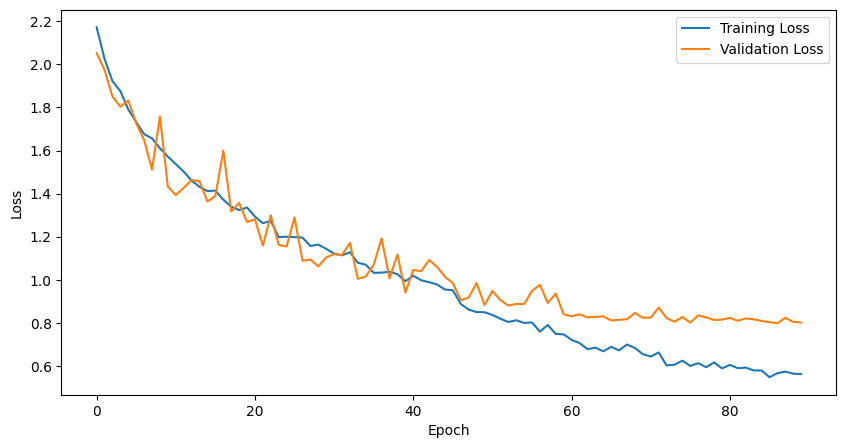

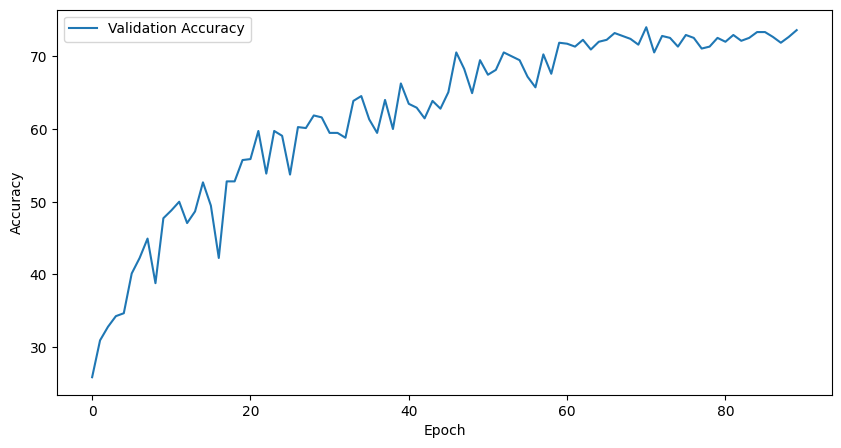

In [13]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()    
plt.show()


### 1.6 Evaluate the trained model on the test set (6 points)

Test Accuracy: 67.07%
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        78
           1       0.59      0.57      0.58        67
           2       0.70      0.82      0.76        66
           3       0.77      0.85      0.81        73
           4       0.74      0.74      0.74        88
           5       0.62      0.55      0.58        73
           6       0.69      0.65      0.67        79
           7       0.65      0.54      0.59        83
           8       0.67      0.74      0.71        74
           9       0.63      0.67      0.65        69

    accuracy                           0.67       750
   macro avg       0.67      0.67      0.67       750
weighted avg       0.67      0.67      0.67       750



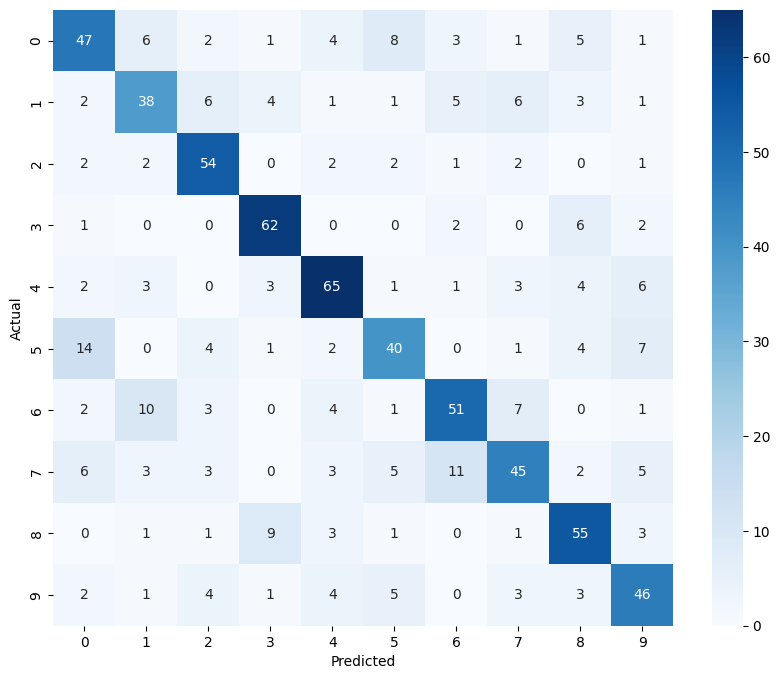

In [31]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
# check test accuracy

from sklearn.metrics import classification_report
y_true = []
y_pred = []
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# classification report
print(classification_report(y_true, y_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 1.7 Conclusion and interpretation (7 points)

  The CNN model achieved an accuracy of approximately %70 on the test set. The confusion matrix can help see the model's performance for each class. 

  **Challenges during training:**

  *   Finding optimal hyperparameter values was challenging.
  *   Avoiding overfitting while still obtaining satisfactory performance was also hard.

  **Potential areas for improvement:**

  *   Maybe using other architectures like ResNet or DenseNet can improve the performance.
  *   Bigger model (cant fit into memory)

  **Overall effectiveness:**

  The chosen CNN architecture, with five convolutional layers and batch normalization, along with ReLU activation and dropout, resulted in a reasonable accuracy on the dataset. However, with more sophisticated training techniques and architecture choices it can be improved.

### 1.8 Kaggle Test Result (5 points)
 The Kaggle test result for the CNN model was 68% which translates to 3.4 when multiplied by the maximum possible score of 5.

 The result is consistent with the performance metrics obtained during validation and testing. The model demonstrates some ability to generalize well and can classify the animal images successfully.

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction

  This part of the assignment explores the concept of transfer learning, where we leverage pre-trained models for image classification. Transfer learning allows us to use knowledge gained from a large dataset (like ImageNet) and apply it to a different, related task. By fine-tuning the last layers, or a larger portion of the model, we can achieve good results with a fraction of the time and effort compared to training from scratch.

  **What is Fine-tuning?**

  Fine-tuning is a transfer learning technique where the weights of a pre-trained model are adjusted (or tuned) to a new task. This helps to utilize the general features learned by the model and learn the particular task of classification of new data more effectively.

  **Why Fine-Tuning?**

  Fine-tuning is effective because:

  *   It leverages existing knowledge and generalizes well.
  *   It significantly reduces training time.
  *   It often leads to improved performance compared to training from scratch, especially on smaller datasets.

  **Why Freeze Lower Layers?**

  Lower layers of a deep CNN capture more generic features (edges, corners), while deeper layers capture task-specific features. Freezing lower layers prevents them from changing drastically during fine-tuning, and also the low level features are often useful for other related task also.

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [ ]:
# delete model for memory
del model

NameError: name 'model' is not defined

In [ ]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.

import torchvision.models as models

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True).to(device)
resnet18.eval()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [ ]:
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the animal-10 image dataset. (base model)


# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the final FC layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10).to(device)



for param in resnet18.fc.parameters():
    param.requires_grad = True



c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# loss
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-5)
# should use lineer weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)


In [ ]:
# train the model
train_losses_res, val_losses_res = [], []
val_accuracies_res = []

epochs = 10
for epoch in range(epochs):
    time_start = time.time()
    resnet18.train()
    train_loss = 0.0
    train_dataset.dataset.transform = train_transform
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses_res.append(train_loss)
    resnet18.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_dataset.dataset.transform = val_test_transform
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criteria(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses_res.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies_res.append(val_accuracy)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"+ f", Validation Accuracy: {val_accuracy:.2f}% in {time.time()-time_start:.2f} sec")


c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/10, Train Loss: 0.3318, Val Loss: 0.2165, Validation Accuracy: 92.80% in 25.37 sec
Epoch 2/10, Train Loss: 0.3111, Val Loss: 0.2062, Validation Accuracy: 93.60% in 24.86 sec
Epoch 3/10, Train Loss: 0.3116, Val Loss: 0.2269, Validation Accuracy: 92.80% in 28.57 sec
Epoch 4/10, Train Loss: 0.3167, Val Loss: 0.1941, Validation Accuracy: 94.40% in 29.00 sec
Epoch 5/10, Train Loss: 0.3091, Val Loss: 0.2351, Validation Accuracy: 92.40% in 28.24 sec


KeyboardInterrupt: 

In [ ]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)


# Load the pre-trained ResNet-18 model
resnet18_2 = models.resnet18(pretrained=True).to(device)

# Freeze all layers
for param in resnet18_2.parameters():
    param.requires_grad = False

# Replace the final FC layer
resnet18_2.fc = nn.Linear(resnet18_2.fc.in_features, 10).to(device)

for param in resnet18_2.fc.parameters():
    param.requires_grad = True

for param in resnet18.layer3.parameters():
    param.requires_grad = True

for param in resnet18.layer4.parameters():
    param.requires_grad = True

c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# training
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_2.parameters(), lr=0.001, weight_decay=1e-5)


train_losses_res2, val_losses_res2 = [], []
val_accuracies_res2 = []

epochs = 10
for epoch in range(epochs):
    time_start = time.time()
    resnet18_2.train()
    train_loss = 0.0
    train_dataset.dataset.transform = train_transform
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_2(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses_res2.append(train_loss)
    resnet18_2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_dataset.dataset.transform = val_test_transform
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_2(images)
            loss = criteria(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses_res2.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies_res2.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"+ f", Validation Accuracy: {val_accuracy:.2f}% in {time.time()-time_start:.2f} sec")

Epoch 1/10, Train Loss: 0.3914, Val Loss: 0.2496, Validation Accuracy: 91.87% in 25.67 sec
Epoch 2/10, Train Loss: 0.3719, Val Loss: 0.2394, Validation Accuracy: 92.00% in 25.55 sec
Epoch 3/10, Train Loss: 0.3500, Val Loss: 0.2582, Validation Accuracy: 91.33% in 24.38 sec
Epoch 4/10, Train Loss: 0.3323, Val Loss: 0.2068, Validation Accuracy: 93.33% in 24.10 sec
Epoch 5/10, Train Loss: 0.3247, Val Loss: 0.2071, Validation Accuracy: 92.53% in 23.99 sec
Epoch 6/10, Train Loss: 0.3303, Val Loss: 0.1922, Validation Accuracy: 93.47% in 22.61 sec
Epoch 7/10, Train Loss: 0.3281, Val Loss: 0.2093, Validation Accuracy: 92.93% in 23.22 sec
Epoch 8/10, Train Loss: 0.3097, Val Loss: 0.2043, Validation Accuracy: 93.07% in 26.08 sec
Epoch 9/10, Train Loss: 0.2901, Val Loss: 0.2110, Validation Accuracy: 92.80% in 26.25 sec
Epoch 10/10, Train Loss: 0.2965, Val Loss: 0.2081, Validation Accuracy: 92.80% in 26.12 sec


In [ ]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)


# Load the pre-trained ResNet-18 model
resnet18_3 = models.resnet18(pretrained=True).to(device)

# dont freeze add new layer
resnet18_3.fc = nn.Linear(resnet18_3.fc.in_features, 10).to(device)

# loss
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_3.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-5, 
    verbose=True
)

c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

train_losses_res3, val_losses_res3 = [], []
val_accuracies_res3 = []

epochs = 10
for epoch in range(epochs):
    time_start = time.time()
    resnet18_3.train()
    train_loss = 0.0
    train_dataset.dataset.transform = train_transform
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18_3(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses_res3.append(train_loss)
    resnet18_3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_dataset.dataset.transform = val_test_transform
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18_3(images)
            loss = criteria(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses_res3.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies_res3.append(val_accuracy)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"+ f", Validation Accuracy: {val_accuracy:.2f}% in {time.time()-time_start:.2f} sec")

Epoch 1/10, Train Loss: 1.2675, Val Loss: 2.6824, Validation Accuracy: 50.67% in 29.13 sec
Epoch 2/10, Train Loss: 0.8809, Val Loss: 0.9611, Validation Accuracy: 71.20% in 29.45 sec
Epoch 3/10, Train Loss: 0.8193, Val Loss: 1.9139, Validation Accuracy: 53.73% in 30.56 sec
Epoch 4/10, Train Loss: 0.7034, Val Loss: 1.2362, Validation Accuracy: 66.93% in 29.81 sec
Epoch 5/10, Train Loss: 0.6401, Val Loss: 0.8128, Validation Accuracy: 74.67% in 30.88 sec
Epoch 6/10, Train Loss: 0.5501, Val Loss: 0.9975, Validation Accuracy: 72.67% in 29.81 sec
Epoch 7/10, Train Loss: 0.5367, Val Loss: 0.8759, Validation Accuracy: 74.13% in 29.02 sec
Epoch 8/10, Train Loss: 0.4820, Val Loss: 0.7292, Validation Accuracy: 79.33% in 29.41 sec


KeyboardInterrupt: 

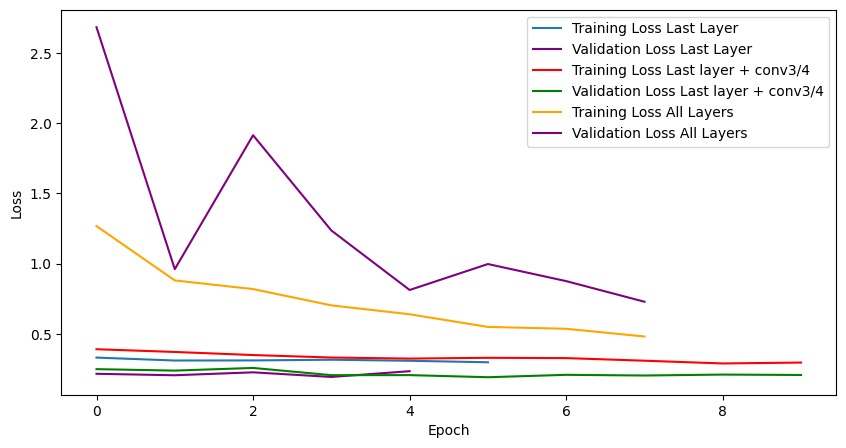

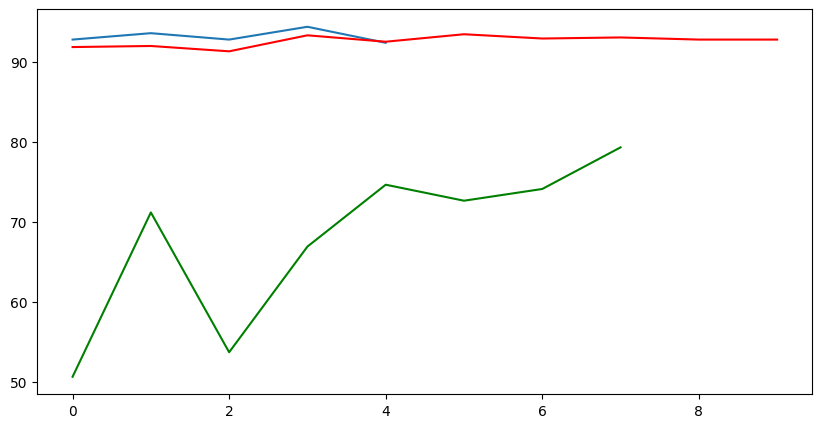

In [ ]:
## Visualize the accuracy and loss changes of the models across training and validation datasets.

plt.figure(figsize=(10, 5))
plt.plot(train_losses_res, label='Training Loss Last Layer')
plt.plot(val_losses_res, label='Validation Loss Last Layer',color='purple')
plt.plot(train_losses_res2, label='Training Loss Last layer + conv3/4', color='red')
plt.plot(val_losses_res2, label='Validation Loss Last layer + conv3/4', color='green')
plt.plot(train_losses_res3, label='Training Loss All Layers', color='orange')
plt.plot(val_losses_res3, label='Validation Loss All Layers', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()   
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies_res, label='Validation Accuracy Last Layer')
plt.plot(val_accuracies_res2, label='Validation Accuracy Last layer + conv3/4', color='red')
plt.plot(val_accuracies_res3, label='Validation Accuracy All Layers', color='green')

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
Interestingly the model with least amount of freedom(first one) performed the best. Which was probably due to architecture being deep and complex enough to learn the features. The second model performed the worst since it was too simple and the last model performed better than the second one but worse than the first one. The first model was the best one with %80 accuracy.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

Test Accuracy: 87.07%
              precision    recall  f1-score   support

           0       0.71      0.90      0.79        78
           1       0.87      0.67      0.76        67
           2       0.85      0.95      0.90        66
           3       0.86      0.93      0.89        73
           4       0.93      0.92      0.93        88
           5       0.97      0.84      0.90        73
           6       0.85      0.80      0.82        79
           7       0.88      0.84      0.86        83
           8       0.93      0.91      0.92        74
           9       0.93      0.94      0.94        69

    accuracy                           0.87       750
   macro avg       0.88      0.87      0.87       750
weighted avg       0.88      0.87      0.87       750



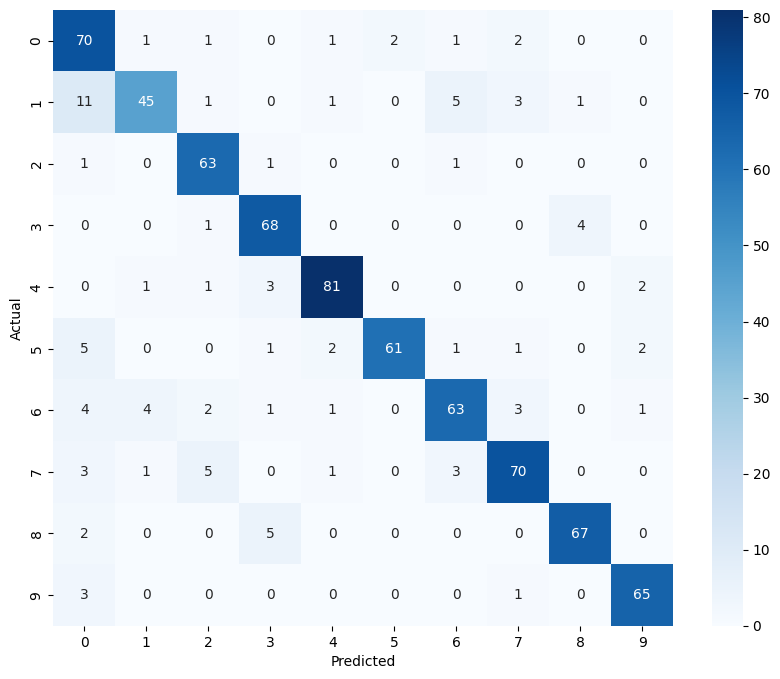

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch

best_model = resnet18_3

if val_accuracies_res[-1] > val_accuracies_res2[-1] and val_accuracies_res[-1] > val_accuracies_res3[-1]:
    best_model = resnet18
if val_accuracies_res2[-1] > val_accuracies_res[-1] and val_accuracies_res2[-1] > val_accuracies_res3[-1]:
    best_model = resnet18_2

from sklearn.metrics import classification_report
y_true = []
y_pred = []
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# classification report
print(classification_report(y_true, y_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# best model 
predictions = predict_images(best_model, image_dir, device)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv("resnet.csv", index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

In [ ]:
del resnet18
del resnet18_2
del resnet18_3

### 2.7. Load the pre-trained MobileNet model (3 points)


In [ ]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.

import torchvision.models as models

# Load the pre-trained MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True).to(device)

print(mobilenet_v2)

c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017BD1B69310>
Traceback (most recent call last):
  File "c:\Users\algos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\U

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [ ]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

# Freeze all layers
for param in mobilenet_v2.parameters():
    param.requires_grad = False

# Replace the final FC layer
mobilenet_v2.classifier[1] = nn.Linear(mobilenet_v2.classifier[1].in_features, 10).to(device)

for param in mobilenet_v2.classifier[1].parameters():
    param.requires_grad = True

# loss
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001, weight_decay=1e-5)

# training
train_losses_mob, val_losses_mob = [], []
val_accuracies_mob = []


In [ ]:
# training
epochs = 10
for epoch in range(epochs):
    time_start = time.time()
    mobilenet_v2.train()
    train_loss = 0.0
    train_dataset.dataset.transform = train_transform
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses_mob.append(train_loss)
    mobilenet_v2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_dataset.dataset.transform = val_test_transform
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet_v2(images)
            loss = criteria(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses_mob.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies_mob.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"+ f", Validation Accuracy: {val_accuracy:.2f}% in {time.time()-time_start:.2f} sec")



Epoch 1/10, Train Loss: 1.1650, Val Loss: 0.4904, Validation Accuracy: 88.00% in 26.05 sec
Epoch 2/10, Train Loss: 0.6014, Val Loss: 0.3349, Validation Accuracy: 91.33% in 26.61 sec
Epoch 3/10, Train Loss: 0.4969, Val Loss: 0.2957, Validation Accuracy: 90.80% in 26.42 sec
Epoch 4/10, Train Loss: 0.4425, Val Loss: 0.2843, Validation Accuracy: 91.73% in 25.75 sec
Epoch 5/10, Train Loss: 0.4062, Val Loss: 0.2396, Validation Accuracy: 92.53% in 25.17 sec
Epoch 6/10, Train Loss: 0.4016, Val Loss: 0.2364, Validation Accuracy: 92.67% in 26.66 sec
Epoch 7/10, Train Loss: 0.3757, Val Loss: 0.2357, Validation Accuracy: 92.00% in 26.74 sec
Epoch 8/10, Train Loss: 0.3596, Val Loss: 0.2118, Validation Accuracy: 93.87% in 26.79 sec
Epoch 9/10, Train Loss: 0.3645, Val Loss: 0.2284, Validation Accuracy: 92.53% in 26.79 sec
Epoch 10/10, Train Loss: 0.3332, Val Loss: 0.2309, Validation Accuracy: 92.67% in 26.98 sec


In [ ]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)


# Load the pre-trained MobileNetV2 model
mobilenet_v2_2 = models.mobilenet_v2(pretrained=True).to(device)

# dont freeze add new layer
mobilenet_v2_2.classifier[1] = nn.Linear(mobilenet_v2_2.classifier[1].in_features, 10).to(device)


## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.
# loss
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_2.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-5, 
    verbose=True
)

train_losses_mob2, val_losses_mob2 = [], []
val_accuracies_mob2 = []


In [ ]:
epochs = 10
for epoch in range(epochs):
    time_start = time.time()
    mobilenet_v2_2.train()
    train_loss = 0.0
    train_dataset.dataset.transform = train_transform
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet_v2_2(images)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses_mob2.append(train_loss)
    mobilenet_v2_2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_dataset.dataset.transform = val_test_transform
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet_v2_2(images)
            loss = criteria(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses_mob2.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies_mob2.append(val_accuracy)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"+ f", Validation Accuracy: {val_accuracy:.2f}% in {time.time()-time_start:.2f} sec")

Epoch 1/10, Train Loss: 1.0117, Val Loss: 1.0245, Validation Accuracy: 71.47% in 35.31 sec
Epoch 2/10, Train Loss: 0.6919, Val Loss: 0.8106, Validation Accuracy: 74.93% in 35.77 sec
Epoch 3/10, Train Loss: 0.6361, Val Loss: 0.6518, Validation Accuracy: 79.73% in 36.68 sec
Epoch 4/10, Train Loss: 0.5827, Val Loss: 0.4932, Validation Accuracy: 84.67% in 39.10 sec
Epoch 5/10, Train Loss: 0.4645, Val Loss: 0.7411, Validation Accuracy: 78.80% in 36.42 sec
Epoch 6/10, Train Loss: 0.4799, Val Loss: 0.6727, Validation Accuracy: 79.73% in 35.97 sec
Epoch 7/10, Train Loss: 0.4289, Val Loss: 0.5052, Validation Accuracy: 84.00% in 35.57 sec
Epoch 8/10, Train Loss: 0.2740, Val Loss: 0.3602, Validation Accuracy: 88.53% in 35.17 sec
Epoch 9/10, Train Loss: 0.1888, Val Loss: 0.3608, Validation Accuracy: 89.60% in 34.97 sec
Epoch 10/10, Train Loss: 0.1816, Val Loss: 0.3411, Validation Accuracy: 90.00% in 35.03 sec


Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

Test Accuracy: 90.40%
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        78
           1       0.89      0.85      0.87        67
           2       0.89      0.97      0.93        66
           3       0.88      0.96      0.92        73
           4       0.99      0.94      0.97        88
           5       0.89      0.92      0.91        73
           6       0.97      0.76      0.85        79
           7       0.82      0.95      0.88        83
           8       0.98      0.86      0.92        74
           9       0.97      0.91      0.94        69

    accuracy                           0.90       750
   macro avg       0.91      0.90      0.90       750
weighted avg       0.91      0.90      0.90       750



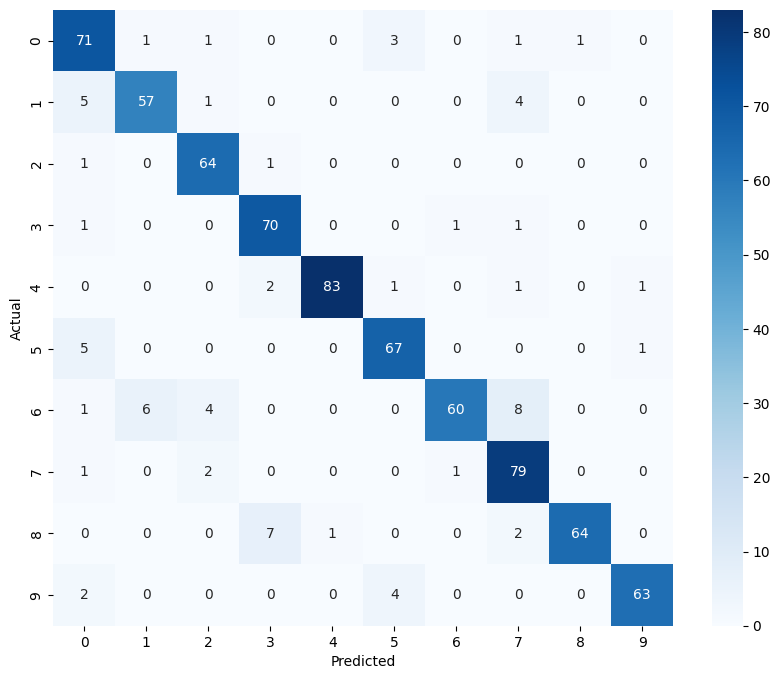

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

best_model = mobilenet_v2_2
if val_accuracies_mob[-1] > val_accuracies_mob2[-1]:
    best_model = mobilenet_v2

from sklearn.metrics import classification_report
y_true = []
y_pred = []
best_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# classification report
print(classification_report(y_true, y_pred))

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:

# best model
predictions = predict_images(best_model, image_dir, device)
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv("mobilenet.csv", index=False)


 The Kaggle test result for the Resnet model was 90% which translates to 4.5 when multiplied by the maximum possible score of 5.

 The result is consistent with the performance metrics obtained during validation and testing. The model demonstrates some ability to generalize well and can classify the animal images successfully.

### Advantages and Disadvantages of Transfer Learning vs. Training from Scratch

**Transfer Learning:**

*   **Advantages:**
    *   **Reduced Training Time:** Transfer learning leverages pre-trained weights, which allows the model to converge much faster than training from random initialization. This can be a significant time-saver.
    *   **Improved Generalization:** Pre-trained models have been trained on vast datasets like ImageNet, which equips them with rich feature extraction capabilities. This results in better generalization on new datasets, especially when the new dataset is not very large.
    *   **Lower Data Requirements:** Transfer learning is effective even when the dataset for the new task is small. The pre-trained features are general enough to be adapted to new contexts with minimal new data.
    *   **Better Performance:** Fine-tuning pre-trained models often yields higher accuracy and better performance metrics compared to training from scratch with a comparable effort.
*   **Disadvantages:**
    *   **Potential for Negative Transfer:** If the source task and the target task are very different, it can sometimes lead to a decrease in performance, compared to training from scratch. However, this is often not a problem when using datasets in the domain of image classification.
    *   **Dependence on Pre-trained Models:** The performance of transfer learning is dependent on the quality and relevance of the chosen pre-trained model. It might need specific model choices depending on the task.
    *   **Limited Control:** The pre-defined architecture of the chosen model limits the freedom of designing the architecture from the ground up, as you can not change the base architecture.

**Training from Scratch:**

*   **Advantages:**
    *   **Flexibility:** You have complete control over the architecture, allowing you to optimize every aspect of the network design for your specific task.
    *   **Adaptability to Specialized Tasks:** Training from scratch can be more effective if you have a very unique dataset or task that has little in common with the general datasets on which pre-trained models are trained.
    *   **No Dependence on Pre-Trained Models:** You are not limited by what pre-trained models are available. This allows for more customization on model architecture.
*   **Disadvantages:**
    *   **Increased Training Time:** Training a CNN from scratch is time consuming, and needs a large amount of time to converge.
    *   **High Data Requirements:** You generally need a much larger labeled dataset to train a CNN from scratch effectively.
    *   **Difficult to Optimize:** Optimization can be tricky, as the starting point is random and hyperparameter tuning can be very time consuming.
    *   **Lower Generalization:** Models trained from scratch tend to overfit to the training data more easily than pre-trained models, which leads to lower generalization.

### Comparison Table of Best Models

| Model               | Training Approach | Accuracy | Training Time |
|---------------------|-------------------|-------------------|--------------|
| CNN from Scratch     | From scratch      | 68%   | Very long    |
| ResNet18 Fine-tuned   | Transfer Learning (All layers fine-tuned)      |  %90   |  Short               |
| MobileNetV2 Fine-tuned | Transfer Learning (All layers fine-tuned)      |  %91  |  Short                   |

### Practical Considerations

When choosing between these approaches, the practical considerations are very important:

*   **Dataset Size:**
    *   If you have a small dataset, transfer learning is the better option.
    *   If you have a large dataset, you can consider training from scratch.
*   **Task Similarity:**
    *   If the new task is very similar to the task the pre-trained model was trained on, then transfer learning is often the best option.
    *   If the new task is very different, then training from scratch can be more effective, although fine-tuning can sometimes still be viable.
*   **Computational Resources:**
    *   If you have limited GPU resources, transfer learning is more suitable because it needs less time and less processing power.
    *   If you have large computational resources, training from scratch is possible but might not be necessary.
*   **Time Constraints:**
    *   If you need a model quickly, transfer learning will save a lot of time.
    *   If time is not a big constraint, you can consider training a model from scratch but note that model design, and hyperparameter tuning take time and resources.
*   **Expertise and Control:**
    *   If you need full control over the architecture, then training from scratch can be better.
    *   If you do not have the resources for designing architectures and hyperparameter tuning, you can use pre-trained models and use transfer learning with minimal effort.
